# Muon identification

In [1]:
import numpy as np
import pandas as pd 
import sklearn
import gc
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import pickle
import random
import math
import seaborn
import time
%matplotlib inline 

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 50)

import lightgbm as lgb
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from tqdm import tqdm_notebook
from sklearn.externals import joblib
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from math import isclose

from itertools import product

In [31]:
for p in [np, pd, sklearn, lgb]:
    print (p.__name__, p.__version__)

numpy 1.14.5
pandas 0.19.2
sklearn 0.19.0
lightgbm 2.0.6


## Data preprocessing

In [2]:
train1 = pd.read_csv('./train_part_1_v2.csv.gz')
train2 = pd.read_csv('./train_part_2_v2.csv.gz')
test_final = pd.read_csv('./test_private_v3_track_1.csv.gz')
submission = pd.read_csv('./sample_submission.csv')

In [3]:
train1 = pd.concat([train1, train2], ignore_index=True)

In [4]:
train1 = train1.replace(-9999, np.nan)
train1 = train1.dropna()

In [5]:
train1 = train1.reset_index(drop=True)

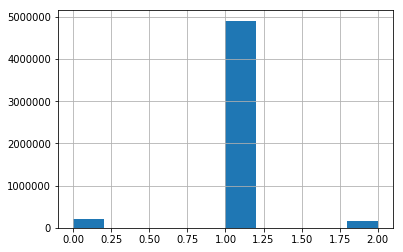

In [8]:
train1['particle_type'].hist()

Muons are overrepresented in our sample. To make amounts of muon and other particles roughly equal I had to discard most of dataset rows corresponding to muons. I checked that such reduction of dataset size doesn't lead to significant decline of prediction quality.

In [6]:
muons_number = train1[train1.particle_type == 1].shape[0]
print("Number of muon particls = {}".format(muons_number))
print("Number of other particls = {}".format(train1.shape[0] - muons_number))

Number of muon particls = 4907392
Number of other particls = 369845


I left 400000 muons in dataset, that is roughly equal to other particles sum.

In [7]:
np.random.seed(5)
sample = np.random.choice(train1[train1.particle_type == 1].index, muons_number - 400000, replace=False)
bad_df = train1.index.isin(sample)
train1 = train1.loc[~bad_df]

In [8]:
train1 = train1.reset_index(drop=True)

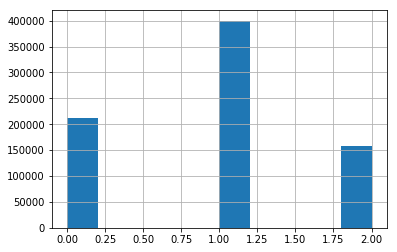

In [9]:
train1['particle_type'].hist()

Now amounts of all three types of particles are comparable, and number of muons is about the same as number of protons and pions in total.

In [10]:
y_values = train1.label.values

In [11]:
train1 = train1.drop(['label'], axis=1)

Below are some functions for making new variables and discarding not very useful ones. I took some function from utils.py from this repository: https://github.com/yandexdataschool/IDAO-2019-muon-id

In [12]:
# These pad constants correspond to pad x and y dimensions. 
# I took them from this document: https://iopscience.iop.org/article/10.1088/1748-0221/3/08/S08005/pdf, page 128,
# table in upper part. Actually they should be used as 0.63 for x dimension of M1 detector and 3.1 for y dimension of M1
# detectors but for some reasons feature appered to become a bit more useful when I used products like 0.63 * 3.1 for both
# x and y dimensions of M1 detector and so on.
PAD0, PAD1, PAD2, PAD3 = 0.63 * 3.1, 0.67 * 3.4, 2.9 * 3.6, 3.1 * 3.9


# These ones I took from utils.py
N_STATIONS = 4
FEATURES_PER_STATION = 6
N_FOI_FEATURES = N_STATIONS*FEATURES_PER_STATION
EMPTY_FILLER = -9000


# This one parses array in form of string. I also took it from utils.py
def parse_array(line, dtype=np.float32):
    return np.fromstring(line[1:-1], sep=" ", dtype=dtype)


# This one finds closes hits to extrapolated track from ones from FOI field. I also took it from utils.py
def find_closest_hit_per_station(row):
    result = np.empty(N_FOI_FEATURES, dtype=np.float32)
    closest_x_per_station = result[0:4]
    closest_y_per_station = result[4:8]
    closest_T_per_station = result[8:12]
    closest_z_per_station = result[12:16]
    closest_dx_per_station = result[16:20]
    closest_dy_per_station = result[20:24]
    
    for station in range(4):
        hits = (row["FOI_hits_S"] == station)
        if not hits.any():
            closest_x_per_station[station] = EMPTY_FILLER
            closest_y_per_station[station] = EMPTY_FILLER
            closest_T_per_station[station] = EMPTY_FILLER
            closest_z_per_station[station] = EMPTY_FILLER
            closest_dx_per_station[station] = EMPTY_FILLER
            closest_dy_per_station[station] = EMPTY_FILLER
        else:
            x_distances_2 = (row["Lextra_X[%i]" % station] - row["FOI_hits_X"][hits])**2
            y_distances_2 = (row["Lextra_Y[%i]" % station] - row["FOI_hits_Y"][hits])**2
            distances_2 = x_distances_2 + y_distances_2
            closest_hit = np.argmin(distances_2)
            closest_x_per_station[station] = x_distances_2[closest_hit]
            closest_y_per_station[station] = y_distances_2[closest_hit]
            closest_T_per_station[station] = row["FOI_hits_T"][hits][closest_hit]
            closest_z_per_station[station] = row["FOI_hits_Z"][hits][closest_hit]
            closest_dx_per_station[station] = row["FOI_hits_DX"][hits][closest_hit]
            closest_dy_per_station[station] = row["FOI_hits_DY"][hits][closest_hit]
    return result


# These function integrates all data processing including something I didn't take from utils.py
def process_df(df):
    # This dist feature uses d2 formula from this poster: 
    # https://indico.cern.ch/event/491582/contributions/1168914/attachments/1236304/1815447/LHCC_Cogoni_v4.pdf wth slight 
    # modifications, see comment about pad constants above.
    df['dist'] = ((df['MatchedHit_X[0]'] - df['Lextra_X[0]']) / PAD0) ** 2 + \
    ((df['MatchedHit_X[1]'] - df['Lextra_X[1]']) / PAD1) ** 2 + \
    ((df['MatchedHit_X[2]'] - df['Lextra_X[2]']) / PAD2) ** 2 + \
    ((df['MatchedHit_X[3]'] - df['Lextra_X[3]']) / PAD3) ** 2 + \
    ((df['MatchedHit_Y[0]'] - df['Lextra_Y[0]']) / PAD0) ** 2 + \
    ((df['MatchedHit_Y[1]'] - df['Lextra_Y[1]']) / PAD1) ** 2 + \
    ((df['MatchedHit_Y[2]'] - df['Lextra_Y[2]']) / PAD2) ** 2 + \
    ((df['MatchedHit_Y[3]'] - df['Lextra_Y[3]']) / PAD3) ** 2
    
    # This feature equals to 1 if all MatchHit_TYPE features for curret object are equal to 1 (i.e all matchs happend). It 
    # equals to zero otherswise.
    df['all_match'] = df['MatchedHit_TYPE[0]'] + df['MatchedHit_TYPE[1]'] + df['MatchedHit_TYPE[2]'] + df['MatchedHit_TYPE[3]']
    df['all_match_one'] = 0
    df.loc[df['all_match'].abs() == 8, 'all_match_one'] = 1
    df = df.drop(['all_match'], axis=1)
    
    # Here I parse some collumns from strings to list. Some of these columns are supposed to be ints, and some - floats.
    col_lst = ['FOI_hits_X', 'FOI_hits_Y', 'FOI_hits_Z', 'FOI_hits_DX', 'FOI_hits_DY', 'FOI_hits_DZ']
    for col in col_lst:
        df[col] = df[col].apply(lambda x: parse_array(x))
        
    col_lst = ['FOI_hits_T', 'FOI_hits_DT', 'FOI_hits_S']
    for col in col_lst:
        df[col] = df[col].apply(lambda x: parse_array(x, dtype=np.int16))
        
    # Here I make closest features using function from utils.py
    df[['closest_x0', 'closest_x1', 'closest_x2', 'closest_x3', 'closest_y0', 'closest_y1', 'closest_y2', 'closest_y3', \
        'closest_t0', 'closest_t1', 'closest_t2', 'closest_t3', 'closest_z0', 'closest_z1', 'closest_z2', 'closest_z3', \
        'closest_dx0', 'closest_dx1', 'closest_dx2', 'closest_dx3', 'closest_dy0', 'closest_dy1', \
        'closest_dy2', 'closest_dy3']] =  df.apply(lambda row: pd.Series(find_closest_hit_per_station(row)), axis = 1)
    
    col_lst = ['FOI_hits_X', 'FOI_hits_Y', 'FOI_hits_Z', 'FOI_hits_DX', 'FOI_hits_DY', \
               'FOI_hits_DZ', 'FOI_hits_T', 'FOI_hits_DT', 'FOI_hits_S']
    
    # I count mean and std for parsed lists.
    for col in col_lst:
        col_mean = col + "_mean"
        col_std = col + "_std"
        df[col_mean] = df[col].apply(lambda x: np.mean(x))
        df[col_std] = df[col].apply(lambda x: np.std(x))
    
    # Here I delete columns that appeared to be useless. For instance, I cannot use columns with lists, though I extracted
    # some useful data from them.
    cols_to_drop = ['ndof', 'FOI_hits_X_mean', 'FOI_hits_Y_mean', 'FOI_hits_X', 'FOI_hits_Y', \
                    'FOI_hits_Z', 'FOI_hits_DX', 'FOI_hits_DY', 'FOI_hits_DZ', 'FOI_hits_T', 'FOI_hits_DT', 'FOI_hits_S']
    df = df.drop(cols_to_drop, axis=1)
    
    # Corresponding Lextra_? and MatchedHit_? were highly correlated. So I made new collumns storing differences between 
    # such columns and deleted Lextra columns.
    for i in range(4):
        new_col_x = 'x_dif_' + str(i)
        lextra_x = 'Lextra_X[{}]'.format(i)
        matched_hit_x = 'MatchedHit_X[{}]'.format(i) 
        df[new_col_x] = df[lextra_x] - df[matched_hit_x]
        
    for i in range(4):
        new_col_y = 'y_dif_' + str(i)
        lextra_y = 'Lextra_Y[{}]'.format(i)
        matched_hit_y = 'MatchedHit_Y[{}]'.format(i)
        df[new_col_y] = df[lextra_y] - df[matched_hit_y]
        
    df = df.drop(['Lextra_X[0]', 'Lextra_X[1]', 'Lextra_X[2]', 'Lextra_X[3]', 'Lextra_Y[0]', \
                  'Lextra_Y[1]', 'Lextra_Y[2]', 'Lextra_Y[3]'], axis=1)
    
    return df    

In [13]:
train1 = process_df(train1)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(train1.drop(['id', 'weight', 'particle_type', 'sWeight','kinWeight'], axis=1), y_values, test_size=0.2, random_state=99)

## Model training

Previously I used GridSearchCV to search for good parameters. It took a while.

In [17]:
%%time
model = lgb.LGBMClassifier(objective='binary', nthread=4)
opt_params = {'min_data_in_leaf': 128, 
              'feature_fraction': 0.75, 
              'learning_rate': 0.035, 
              'n_estimators': 1000, 
              'verbose': 0, 
              'num_leaves': 512, 
              'bagging_fraction': 0.8, 
              'reg_lambda': 0.1, 
              'bagging_freq': 1, 
              'bagging_seed': 128}
model.set_params(**opt_params)
model.fit(X_train, y_train)
pred_lgb = model.predict(X_test)

c:\users\julia\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Wall time: 8min 46s


In [18]:
pred_lgb_proba = model.predict_proba(X_test)
print('Test rsem for LightGBM is %f' % np.sqrt(mean_squared_error(y_test, pred_lgb_proba[:,1])))

Test rsem for LightGBM is 0.367271


## Prediction for private test

In [20]:
test_final = process_df(test_final)

In [27]:
test_final = test_final.drop(['id'], axis=1)

In [28]:
pred_lgb = model.predict_proba(test_final)
pred_lgb = pred_lgb[:,1]

In [30]:
with open("submission_final.csv", "w") as f:
    f.write("id,prediction\n")
    for i in range(test_final.shape[0]):
        f.write("%d,%.3f\n" % (i, pred_lgb[i]))

[Had to cut some decimals to fit into submission system file size limit]